# Automated Model Discovery for Brain Tissue

Model Discovery Papers:
1. Invariant-based: https://www.sciencedirect.com/science/article/pii/S1742706123000661
2. Principal-stretch-based: https://www.sciencedirect.com/science/article/pii/S2666522023000047

Brain Data Reference: https://www.sciencedirect.com/science/article/pii/S1742706116305633

Code by Skyler St. Pierre & Kevin Linka \\
Last edited August 2023


## Problem description

A hyperelastic or Green-elastic materials with can directly be defined by the Piola stress
$$
  \mathbf{P}
= \frac{\partial \psi (\mathbf{F})}{\partial \mathbf{F}} \,,
$$
in dependency of the strain energy function $\Psi$ and the deforation gradient $\mathbf{F}$. Now, by contraining the material symmetry to the special case of isotropy, the strain energy function can be given as a function of the first three strain invariants as $\Psi(I_1, \, I_2,\, I_3)$


We can further constrain the choice of the free energy function $\psi$ for the special case of perfect incompressibility for which the Jacobian remains constant and equal to one, $I_3 = 1$. So we obtain for the Piola stress tensor
$$
  \mathbf{P}
= \frac{\partial \psi}{\partial I_1} \frac{\partial I_1}{\partial \mathbf{F}}
+ \frac{\partial \psi}{\partial I_2} \frac{\partial I_2}{\partial \mathbf{F}}
- p\, \mathbf{F}^{\rm {-t}}  
~~~~~=~~~~~ 2 \left[\frac{\partial \psi}{\partial I_1}
   + I_1 \frac{\partial \psi}{\partial I_2} \right] \mathbf{F}
-2 \frac{\partial \psi}{\partial I_2}
   \mathbf{F} \cdot \mathbf{F}^{\rm {t}} \cdot \mathbf{F}
- p\, \mathbf{F}^{\rm {-t}} \, .     
$$

This implies that we reduce the input to a set of only two invariants, $I_1$ and $I_2$ as functional basis of the strain energy we want to obtain.


Before we start with discovering the strain energy function, dependent on the first two invariants, we have to initialize all necessary python pckages and load the brain data.




### 0. Load python packages

In [1]:
# matplotlib 3.7 and above removed key plotting features used in this notebook; tensorflow is starting to move some aspects to legacy in 2.13.0 but it will run still
!pip install matplotlib==3.2.2
!pip install tensorflow==2.12.0

In [ ]:
# import necessary python packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import json
import pandas as pd
import os
import copy
from sklearn.metrics import r2_score


# Check Versions
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__) # must be 3.2.2
print('Tensorflow: ' + tf.__version__)
print('Keras: ' + keras.__version__) # comment out if using tf 2.13.0

Numpy: 1.23.5
Matplotlib: 3.2.2
Tensorflow: 2.12.0
Keras: 2.12.0


In [ ]:
#Import excel file, change to match where you saved the file
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/CANNs_Class/' # change to where you download this; must be in Google Drive
dfs = pd.read_excel(path + 'input/CANNsBRAINdata.xlsx', sheet_name='Sheet1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Load Brain data

Text(0.5, 1.0, 'corpus callosum: compression & tension')

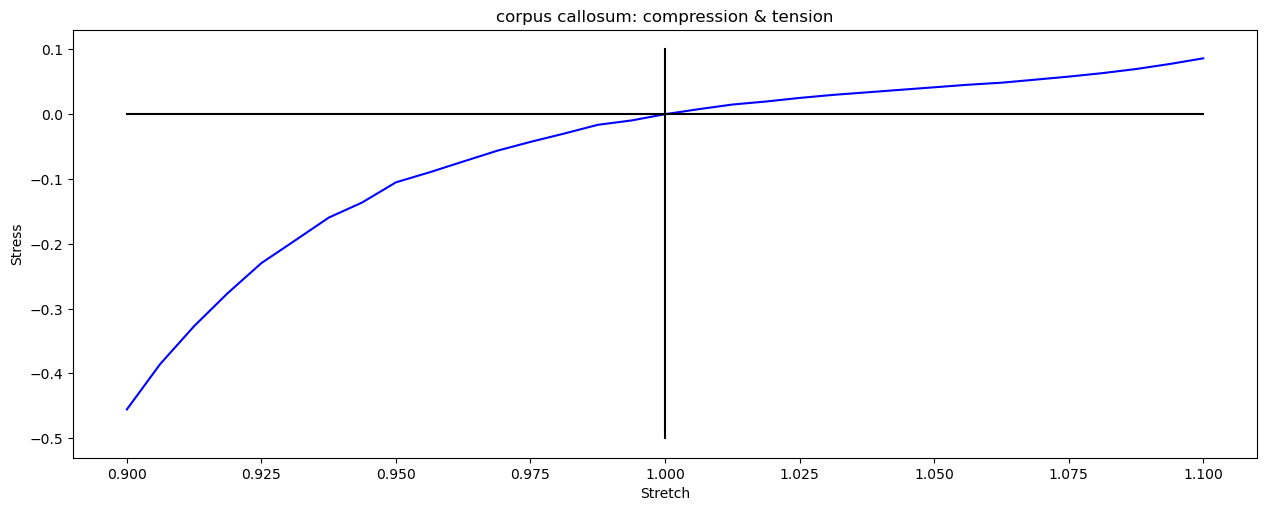

In [ ]:
# Load data for different brain regions
def getStressStrain(Region):

    if Region =='CX':
        P_ut = dfs.iloc[3:,1].dropna().astype(np.float64)
        lam_ut = dfs.iloc[3:,0].dropna().astype(np.float64)

        P_ss = dfs.iloc[3:,3].dropna().astype(np.float64).values
        gamma_ss = dfs.iloc[3:,2].dropna().astype(np.float64).values
    elif Region =='CR':
        P_ut = dfs.iloc[3:,6].dropna().astype(np.float64)
        lam_ut = dfs.iloc[3:,5].dropna().astype(np.float64)

        P_ss = dfs.iloc[3:,8].dropna().astype(np.float64).values
        gamma_ss = dfs.iloc[3:,7].dropna().astype(np.float64).values
    elif Region =='BG':
        P_ut = dfs.iloc[3:,11].dropna().astype(np.float64)
        lam_ut = dfs.iloc[3:,10].dropna().astype(np.float64)

        P_ss = dfs.iloc[3:,13].dropna().astype(np.float64).values
        gamma_ss = dfs.iloc[3:,12].dropna().astype(np.float64).values
    elif Region =='CC':
        P_ut = dfs.iloc[3:,16].dropna().astype(np.float64)
        lam_ut = dfs.iloc[3:,15].dropna().astype(np.float64)

        P_ss = dfs.iloc[3:,18].dropna().astype(np.float64).values
        gamma_ss = dfs.iloc[3:,17].dropna().astype(np.float64).values

    return P_ut, lam_ut, P_ss, gamma_ss

# Define different loading protocols
def traindata(modelFit_mode):
    if modelFit_mode == 'T':
        model_given = model_UT
        input_train = lam_ut[16:]
        output_train = P_ut[16:]
        sample_weights = np.array([1.0]*input_train.shape[0])

    elif modelFit_mode == "C":
        model_given = model_UT
        input_train = lam_ut[:17]
        output_train = P_ut[:17]
        sample_weights = np.array([1.0]*input_train.shape[0])

    elif modelFit_mode == "SS":
        model_given = model_SS
        input_train = gamma_ss
        output_train = P_ss
        sample_weights = np.array([1.0]*input_train.shape[0])

    elif modelFit_mode == "TC_and_SS":
        model_given = model
        input_train = [[lam_ut], [gamma_ss]]
        output_train = [[P_ut], [P_ss]]
        # Weigh all stresses the same in the loss fn (normalize to 1)
        sample_weights_tc = np.array([1.0] * lam_ut.shape[0])
        sample_weights_tc[17:] = 1/np.abs(P_ut[17:])
        sample_weights_tc[:16] = 1/np.abs(P_ut[:16])
        sample_weights_ss = np.array([1.0] * gamma_ss.shape[0])
        sample_weights_ss[17:] = 1/np.abs(P_ss[17:])
        sample_weights_ss[:16] = 1/np.abs(P_ss[:16])
        sample_weights = [[sample_weights_tc], [sample_weights_ss]]
    return model_given, input_train, output_train, sample_weights


Region_test = 'CC'  # corpus callosum
P_ut, lam_ut, P_ss, gamma_ss = getStressStrain(Region_test)

plt.figure(figsize=(1100/72,400/72))
plt.plot(lam_ut,P_ut,color='blue')
plt.plot(np.linspace(0.9, 1.1, 100), np.linspace(0,0,100),'k')
plt.plot(np.linspace(1, 1, 100), np.linspace(-0.5,0.1,100),'k')
plt.xlabel('Stretch')
plt.ylabel('Stress')
plt.title('corpus callosum: compression & tension')

Text(0.5, 1.0, 'corpus callosum: shear')

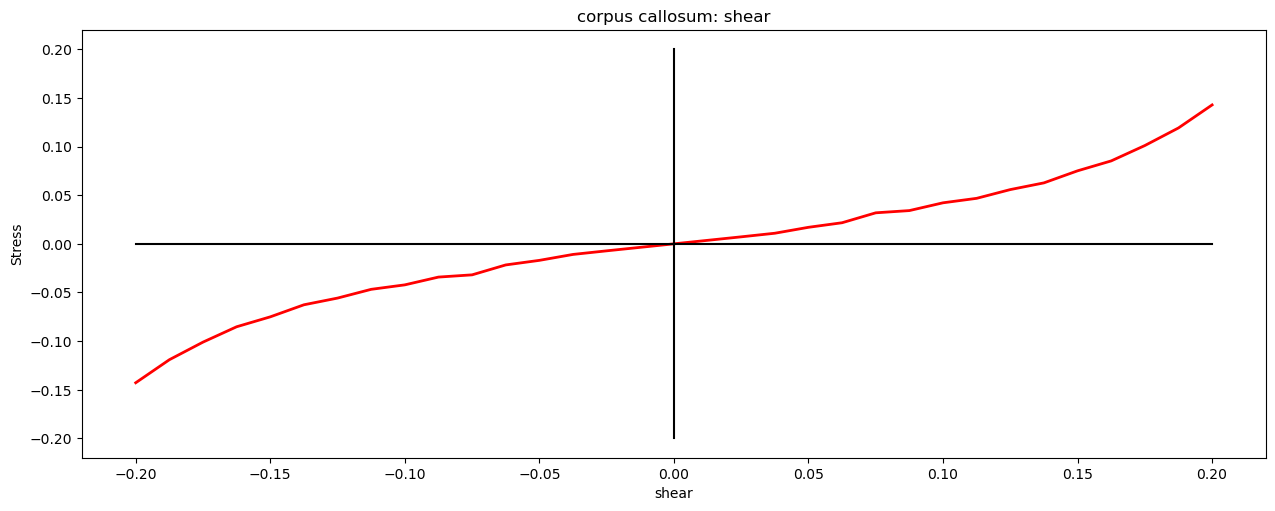

In [ ]:
# plotshear
plt.figure(figsize=(1100/72,400/72))
plt.plot(gamma_ss,P_ss, linewidth=2.0,color='red')
plt.plot(np.linspace(-0.2, 0.2, 100), np.linspace(0,0,100),'k')
plt.plot(np.linspace(0, 0, 100), np.linspace(-0.2,0.2,100),'k')
plt.xlabel('shear')
plt.ylabel('Stress')
plt.title('corpus callosum: shear')

### L1 and L2 regularization with penalty weight



In [ ]:
def regularize(reg, pen):
    if reg == 'L2':
        return keras.regularizers.l2(pen)
    if reg == 'L1':
        return keras.regularizers.l1(pen)

## 2a. Strain Energy Model - Invariant-based


Next, we define the strain energy function for our isotropic, perfectly incompressible Constitutive Artificial Neural Network with two hidden layers and four and twelve nodes using the invariants of the right Cauchy Green tensor. The first layer generates powers $(\circ)^1$ and $(\circ)^2$ of the network inputs,
$[I_1-3]$ and $[I_2-3]$, and the second layer applies the identity, $(\circ)$, the exponential function, $(\rm{exp}((\circ))-1)$, and the natural logarithm, $(-\rm{ln}(1-(\circ)))$, to these powers.
The set of equations for this networks takes the following explicit form,


$$
\begin{array}{l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{.02cm}}l@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.04cm}}
              l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.0cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.0cm}}l}
    \psi(I_1,I_2)
&=& w_{2,1}&w_{1,1} &[\,I_1 - 3\,]
&+& w_{2,2} & [ \, \exp (\,     w_{1,2} & [\, I_1 -3 \,]&)   - 1\,]
&-& w_{2,3} &      \ln (\, 1 -  w_{1,3} & [\, I_1 -3 \,]&) \\
&+& w_{2,4}&w_{1,4} &[\,I_1 - 3\,]^2
&+& w_{2,5} & [ \, \exp (\,     w_{1,5} & [\, I_1 -3 \,]^2&) - 1\,]
&-& w_{2,6} &      \ln (\, 1 -  w_{1,6} & [\, I_1 -3 \,]^2&) \\
&+& w_{2,7}&w_{1,7} &[\,I_2 - 3\,]
&+& w_{2,8} & [ \, \exp (\,     w_{1,8} & [\, I_2 -3 \,]&)   - 1\,]
&-& w_{2,9} &      \ln (\, 1 -  w_{1,9} & [\, I_2 -3 \,]&)\\
&+& w_{2,10}&w_{1,10} &[\,I_2 - 3\,]^2
&+& w_{2,11} & [ \, \exp (\,    w_{1,11} & [\, I_2 -3 \,]^2&)- 1\,]
&-& w_{2,12} &      \ln (\, 1 - w_{1,12} & [\, I_2 -3 \,]^2&) \,.
\end{array}
$$


First we define the activation functions and a single Invariant block:

In [ ]:
initializer_exp = tf.keras.initializers.RandomUniform(minval=0., maxval=0.1, seed=np.random.randint(0,10000)) # use random integer as seed
initializer_1 = 'glorot_normal'

# Self defined activation functions for exp term
def activation_Exp(x):
    return 1.0*(tf.math.exp(x) -1.0)
# Self defined activation functions for ln term
def activation_ln(x):
    return -1.0*tf.math.log(1.0 - (x))

# Define network block
def SingleInvNet(I1_ref, idi, reg, pen):

    # input: invariant
    I_1_w11 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(1+idi)+'1')(I1_ref) # no activation
    I_1_w21 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(2+idi)+'1')(I1_ref) # exp activation

    I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                              use_bias=False, activation=activation_ln,name='w'+str(3+idi)+'1')(I1_ref) # ln activation

    # input: invariant^2
    I_1_w41 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(4+idi)+'1')(tf.math.square(I1_ref)) # no activation
    I_1_w51 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(5+idi)+'1')(tf.math.square(I1_ref)) # exp activation
    I_1_w61 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                              use_bias=False, activation=activation_ln,name='w'+str(6+idi)+'1')(tf.math.square(I1_ref)) # ln activation

    collect = [I_1_w11, I_1_w21, I_1_w31, I_1_w41, I_1_w51, I_1_w61]
    collect_out = tf.keras.layers.concatenate(collect, axis=1)

    return collect_out

Then we define the strain energy keras submodel as:

In [ ]:
def StrainEnergyCANN_invariant(reg, pen):

    # Inputs defined
    I1_in = tf.keras.Input(shape=(1,), name='I1')
    I2_in = tf.keras.Input(shape=(1,), name='I2')


    # Put invariants in the reference configuration
    I1_ref = keras.layers.Lambda(lambda x: (x-3.0))(I1_in)
    I2_ref = keras.layers.Lambda(lambda x: (x-3.0))(I2_in)

    I1_out = SingleInvNet(I1_ref, 0, reg, pen)
    terms = I1_out.get_shape().as_list()[1] # 6 terms per invariant
    I2_out = SingleInvNet(I2_ref, terms, reg, pen)

    ALL_I_out = [I1_out,I2_out]
    ALL_I_out = tf.keras.layers.concatenate(ALL_I_out,axis=1)

    # second layer
    W_ANN = keras.layers.Dense(1,kernel_initializer='glorot_normal',kernel_constraint=keras.constraints.NonNeg(),
                               kernel_regularizer=regularize(reg, pen),
                           use_bias=False, activation=None,name='wx2')(ALL_I_out)
    Psi_model = keras.models.Model(inputs=[I1_in, I2_in], outputs=[W_ANN], name='Psi')

    return Psi_model, terms*2  # 12 terms



## 2b. Strain Energy Model - Principal-stretch-based


Next, we define the strain energy function for our isotropic, perfectly incompressible Constitutive Artificial Neural Network with one hidden layers and twenty nodes using the principal stretches.
The set of equations for this network takes the following explicit form,


$$ \begin{array}{l@{\hspace*{0.05cm}}r@{\hspace*{0.05cm}}
              l@{\hspace*{0.05cm}}l@{\hspace*{0.00cm}}
              c@{\hspace*{0.05cm}}c@{\hspace*{0.05cm}}
              l@{\hspace*{0.05cm}}l@{\hspace*{0.00cm}}
              l@{\hspace*{0.05cm}}c@{\hspace*{0.05cm}}
              l@{\hspace*{0.05cm}}l@{\hspace*{0.00cm}}l}
   \psi
&= \sum_{i=1}^3 &
    w_1   &[\lambda_i^{-30}&-1]
&+& w_2   &[\lambda_i^{-28}&-1]
&+& w_3   &[\lambda_i^{-26}&-1] \\
&+& w_4   &[\lambda_i^{-24}&-1]
&+& w_5   &[\lambda_i^{-22}&-1]  
&+& w_6   &[\lambda_i^{-20}&-1] \\
&+& w_7   &[\lambda_i^{-18}&-1]
&+& w_8   &[\lambda_i^{-16}&-1]
&+& w_9   &[\lambda_i^{-14}&-1]  \\
&+& w_{10}&[\lambda_i^{-12}&-1]
&+& w_{11}&[\lambda_i^{-10}&-1]
&+& w_{12}&[\lambda_i^{-8}&-1] \\
&+& w_{13}&[\lambda_i^{-6}&-1]
&+& w_{14}&[\lambda_i^{-4}&-1]
&+& w_{15}&[\lambda_i^{-2}&-1] \\
&+& w_{16}&[\lambda_i^{+2}&-1]
&+& w_{17}&[\lambda_i^{+4}&-1]
&+& w_{18}&[\lambda_i^{+6}&-1] \\
&+& w_{19}&[\lambda_i^{+8}&-1]
&+& w_{20}&[\lambda_i^{+10}&-1]&
\end{array}
$$

In [ ]:
def SingleInvNetStretch(I1_ref, reg, pen):
    I_1_w11 = keras.layers.Dense(1, kernel_initializer=initializer_1, kernel_constraint=keras.constraints.NonNeg(),
                                 use_bias=False, activation=None, kernel_regularizer=regularize(reg, pen))(I1_ref)
    return I_1_w11


def princStretch(inputs): # convert invariants to principal stretches
    (I1_in, I2_in) = inputs
    Stretch_1_0 = 1.0

    Q = (tf.math.pow(I1_in, 2) - 3.0 * I2_in) + 0.001
    R = ((-9.0 * I1_in * I2_in) + 27.0 + (2.0 * tf.math.pow(I1_in, 3)))
    Theta = tf.math.acos(R / (2.0 * tf.math.pow(Q, 3 / 2)))

    Stretch_1 = 1.0 / 3.0 * (
                I1_in + 2.0 * tf.math.sqrt(Q) * tf.math.cos(1.0 / 3.0 * (Theta + 2.0 * np.pi * (1.0 - 1.0))))
    Stretch_2 = 1.0 / 3.0 * (
                I1_in + 2.0 * tf.math.sqrt(Q) * tf.math.cos(1.0 / 3.0 * (Theta + 2.0 * np.pi * (2.0 - 1.0))))
    Stretch_3 = 1.0 / 3.0 * (
                I1_in + 2.0 * tf.math.sqrt(Q) * tf.math.cos(1.0 / 3.0 * (Theta + 2.0 * np.pi * (3.0 - 1.0))))

    return tf.math.sqrt(Stretch_1), tf.math.sqrt(Stretch_2), tf.math.sqrt(Stretch_3), Q

def StrainEnergyCANN_stretch(reg, pen):
    # Inputs defined
    I1_in = tf.keras.Input(shape=(1,), name='I1')
    I2_in = tf.keras.Input(shape=(1,), name='I2')
    # Get principal stretches
    Stretch_1, Stretch_2, Stretch_3, Q = keras.layers.Lambda(function=princStretch,
                                                             name='P_stretch')([I1_in, I2_in])
    ALL_I_out_arr = []
    for i in range(-30, 12, 2):  # define range of exponential powers and number of terms
        if i != 0:
            stretch_out = SingleInvNetStretch(Stretch_1 ** i + Stretch_2 ** i + Stretch_3 ** i - 3.0, reg, pen)
            ALL_I_out_arr.append(stretch_out)
    ALL_I_out = tf.keras.layers.concatenate(ALL_I_out_arr, axis=1)
    amount_terms = len(ALL_I_out_arr)

    ### Special cases: NH, BK, 1-term models ###
    # ALL_I_out = SingleInvNetStretch(Stretch_1 ** (-2) + Stretch_2 ** (-2) + Stretch_3 ** (-2) - 3.0, reg, pen)
    # amount_terms = 1
    ####

    Psi_model = keras.models.Model(inputs=[I1_in, I2_in], outputs=[ALL_I_out], name='Psi')

    return Psi_model, amount_terms

### 3. Stress Models


####  Tension and compression

For the case of uniaxial tension and compression, we stretch the specimen in one direction,
$F_{11} = \lambda_1 = \lambda$.
For an isotropic, perfectly incompressible material with
$I_3 = \lambda_1^2  \lambda_2^2  \lambda_3^2 = 1$,
the stretches orthogonal to the loading direction are identical and equal to the square root of the stretch,
$F_{22} = \lambda_2 = \lambda^{-1/2}$ and
$F_{33} = \lambda_3 = \lambda^{-1/2}$.
From the resulting deformation gradient,
$F= {\rm{diag}} \, \{ \; \lambda, \lambda^{-1/2}, \lambda^{-1/2} \,\}$,
we calculate the first and second invariants and their derivatives,

$$
  I_1
= \lambda^2 + \frac{2}{\lambda}
  \quad \mbox{and} \quad
  I_2
= 2\lambda + \frac{1}{\lambda^2}
  \quad \mbox{with} \quad
  \frac{\partial I_1}{\partial  \lambda}
= 2 \, \left[\lambda - \frac{1}{\lambda^2} \right]
  \quad \mbox{and} \quad
  \frac{\partial I_2}{\partial  \lambda}
= 2 \, \left[1 - \frac{1}{\lambda^3}\right] \,,
$$

to evaluate the nominal uniaxial stress $P_{11}$
using the general stress-stretch relationship for perfectly incompressible materials,
$ P_{ii}
= [{\partial \psi}/{\partial I_1}] \,
  [{\partial I_1} /{\partial \lambda_i}]
+ [{\partial \psi}/{\partial I_2}] \,
  [{\partial I_2} /{\partial \lambda_i}]
- [{1}/{\lambda_i}] \, p $,
for $i = 1,2,3$.
Here, $p$ denotes the hydrostatic pressure that we determine from the zero stress condition in the transverse directions, $P_{22} = 0$ and $P_{33} = 0$, as
$ p
= [{2}/{\lambda}] \;
  {\partial \psi}/{\partial I_1}
+ [2\lambda+{2}/{\lambda^2}] \,
  {\partial \psi}/{\partial I_2}$.
This results in the following explicit uniaxial stress-stretch relation for perfectly incompressible, isotropic materials,

$$
  P_{11}
= 2 \,
  \left[
  \frac{\partial \psi}{\partial I_1}
+ \frac{1}{\lambda}
  \frac{\partial \psi}{\partial I_2}
  \right]
  \left[
  \lambda - \frac{1}{\lambda^2}
  \right]\,.
$$


In [ ]:
def Stress_calc_TC(inputs):
    (dPsidI1, dPsidI2, Stretch) = inputs
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')
    minus  = two * (dPsidI1 *  one/ K.square(Stretch)  + dPsidI2 * one/K.pow(Stretch,3))
    stress = two * (dPsidI1 *  Stretch + dPsidI2 * one) - minus

    return stress

####  Shear

For the case of simple shear, we shear the specimen in one direction, $F_{12} = \gamma$.
For an isotropic, perfectly incompressible material with
$F_{11} = F_{22} = F_{33} = 1$,
we calculate the first and second invariants and their derivatives,
$$
  I_1
= 3 + \gamma^2
  \quad \mbox{and} \quad
  I_2
= 3 + \gamma^2
  \quad \mbox{with} \quad
  \frac{\partial I_1}{\partial  \lambda}
= 2 \, \gamma
  \quad \mbox{and} \quad
  \frac{\partial I_2}{\partial  \lambda}
= 2 \, \gamma \,,
$$
to evalute the nominal shear stress $P_{12}$
using the general stress-stretch relationship for perfectly incompressible materials.
This results in the following explicit shear stress-strain relation for perfectly incompressible, isotropic materials,
$$
  P_{12}
= 2\,
  \left[
  \frac{\partial \psi}{\partial I_1}
+ \frac{\partial \psi}{\partial I_2}
  \right]
  \gamma\,.
$$


In [ ]:
# Simple shear stress P12
def Stress_cal_SS(inputs):
    (dPsidI1, dPsidI2, gamma) = inputs
    two = tf.constant(2.0,dtype='float32')
    stress = two * gamma * (dPsidI1  + dPsidI2)

    return stress

Finally, we can define seperate stress models for tension/compression, shear and a combination of all loading states.

In [ ]:
# Gradient function
def myGradient(a, b):
    der = tf.gradients(a, b, unconnected_gradients='zero')
    return der[0]

def modelArchitecture(Psi_model):
    # Stretch and Gamma as input
    Stretch = keras.layers.Input(shape = (1,),
                                  name = 'Stretch')
    Gamma = keras.layers.Input(shape = (1,),
                                  name = 'gamma')

    # specific Invariants UT
    I1_UT = keras.layers.Lambda(lambda x: x**2   + 2.0/x  )(Stretch)
    I2_UT = keras.layers.Lambda(lambda x: 2.0*x  + 1/x**2 )(Stretch)
    # specific Invariants SS
    I1_SS = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma)
    I2_SS = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma)

    #% load specific models
    Psi_UT = Psi_model([I1_UT, I2_UT])
    Psi_SS = Psi_model([I1_SS, I2_SS])

    # derivative UT
    dWI1_UT  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_UT, I1_UT])
    dWdI2_UT = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_UT, I2_UT])
    # derivative SS
    dWI1_SS  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_SS, I1_SS])
    dWdI2_SS = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_SS, I2_SS])

    # Stress UT
    Stress_UT = keras.layers.Lambda(function = Stress_calc_TC,
                                name = 'Stress_UT')([dWI1_UT,dWdI2_UT,Stretch])
    # Stress SS
    Stress_SS = keras.layers.Lambda(function = Stress_cal_SS,
                                name = 'Stress_SS')([dWI1_SS,dWdI2_SS,Gamma])


    # Define model for different load case
    model_UT = keras.models.Model(inputs=Stretch, outputs= Stress_UT)
    model_SS = keras.models.Model(inputs=Gamma, outputs= Stress_SS)
    # Combined model
    model = keras.models.Model(inputs=[model_UT.inputs, model_SS.inputs], outputs=[model_UT.outputs, model_SS.outputs])

    return model_UT, model_SS, Psi_model, model


### 4. Compile model

The compiler definition comprises the loss function definition (here a mean squared error metric), the optimizer (here an Adam optimizer) and the evaluation metric (also mean squared error).

Moreover, we define model callbacks and the keras fit function. The latter obtains the information about which model we want to fit with which data.

In [ ]:
# Optimization utilities
def Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint, sample_weights):

    mse_loss = keras.losses.MeanSquaredError()
    metrics  =[keras.metrics.MeanSquaredError()]
    opti1    = tf.optimizers.Adam(learning_rate=0.001)

    model_given.compile(loss=mse_loss,
                  optimizer=opti1,
                  metrics=metrics)

    # if training loss starts to increase, stop training after 3000 additional epochs = "patience"
    es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=3000, restore_best_weights=True)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True, # save only the best weights across all epochs
    )


    history = model_given.fit(input_train,
                        output_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.0,
                        callbacks=[es_callback, modelckpt_callback], # save best weights if stop early or go through all epochs
                        shuffle = True,
                        verbose = 0, # verbose = 2 will print loss each epoch
                        sample_weight = sample_weights)

    return model_given, history


### 5. Plot functions

Here we define some plot functions to be used to plot the results later on

In [ ]:
def plotLoss(axe, history):
    axe.plot(history)
    axe.set_yscale('log')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

In [ ]:
# plot the contribution of each term to the model stress prediction

def color_map(ax, stretch, model, model_weights, Psi_model, cmaplist, terms, model_type):
    predictions = np.zeros([stretch.shape[0], terms])
    model_plot = copy.deepcopy(model_weights)  # deep copy model weights

    for i in range(terms):
        if model_type == 'Stretch':
            model_plot = np.zeros_like(model_weights)  # wx1 all set to zero
            model_plot[i] = model_weights[i]  # wx1[i] set to trained value
        else:  # for architectures with multiple layers (VL, invariant)
            model_plot[-1] = np.zeros_like(model_weights[-1])  # wx2 all set to zero
            model_plot[-1][i] = model_weights[-1][i]  # wx2[i] set to trained value

        Psi_model.set_weights(model_plot)
        lower = np.sum(predictions, axis=1)
        upper = lower + model.predict(stretch, verbose=0)[:].flatten()
        predictions[:, i] = model.predict(stretch, verbose=0)[:].flatten()
        ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[i],
                         label=i + 1)
        # if i == 0:  # one or two term models, get the correct color
        #     ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[0],
        #                      label=i + 1)
        # else:
        #     ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[7],
        #                      label=i + 1)
        ax.plot(stretch, upper, lw=0.4, zorder=34, color='k')


In [ ]:
plt.rcParams['xtick.major.pad'] = 14 # set plotting parameters
plt.rcParams['ytick.major.pad'] = 14

# plot tension, compression, and shear brain data with color maps

def plotMapTen(ax, Psi_model, model_weights, model_UT, terms, lam_ut, P_ut, Region, path2saveResults, modelFit_mode, model_type):
    if model_type == 'Invariant':
        numTerms = 12
    elif model_type == 'Stretch':
        numTerms = 20  # change if change range
    cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
    # this way, we can use 1 or 2 term models and have the colors be the same for those terms
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([1, 1.02, 1.04, 1.06, 1.08, 1.1])
    ax.set_xlim(1, 1.1)
    if Region == 'CX':
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
        ax.set_ylim(0, 0.4151)
    elif Region == 'BG':
        ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16])
        ax.set_ylim(0, 0.1778)
    elif Region == 'CR':
        ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16])
        ax.set_ylim(0, 0.1582)
    elif Region == 'CC':
        ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])
        ax.set_ylim(0, 0.0862)
    color_map(ax, lam_ut, model_UT, model_weights, Psi_model, cmaplist, terms, model_type)
    ax.scatter(lam_ut, P_ut, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Tension_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.close();


def plotMapCom(ax, Psi_model, model_weights, model_UT, terms, lam_ut, P_ut, Region, path2saveResults, modelFit_mode, model_type):
    if model_type == 'Invariant':
        numTerms = 12
    elif model_type == 'Stretch':
        numTerms = 20  # change if change range
    cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([1, 0.98, 0.96, 0.94, 0.92, 0.9])
    ax.set_xlim(1, 0.9)
    if Region == 'CX':
        ax.set_yticks([0, -0.22, -0.44, -0.66, -0.88, -1.1])
        ax.set_ylim(0, -1.1484)
    elif Region == 'BG':
        ax.set_yticks([0, -0.1, -0.2, -0.3, -0.4, -0.5])
        ax.set_ylim(0, -0.5528)
    elif Region == 'CR':
        ax.set_yticks([0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7])
        ax.set_ylim(0, -0.7591)
    elif Region == 'CC':
        ax.set_yticks([0, -0.1, -0.2, -0.3, -0.4])
        ax.set_ylim(0, -0.4555)
    color_map(ax, lam_ut, model_UT, model_weights, Psi_model, cmaplist, terms, model_type)
    ax.scatter(lam_ut, P_ut, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Compression_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.close();


def plotMapShear(ax, Psi_model, model_weights, model_SS, terms, gamma_ss, P_ss, Region, path2saveResults, modelFit_mode, model_type):
    if model_type == 'Invariant':
        numTerms = 12
    elif model_type == 'Stretch':
        numTerms = 20  # change if change range
    cmap = plt.cm.get_cmap('jet_r', terms)  # define the colormap with the number of terms from the full network
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([0, 0.05, 0.1, 0.15, 0.2])
    ax.set_xlim(0, 0.2)
    if Region == 'CX':
        ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
        ax.set_ylim(0, 0.5435)
    elif Region == 'BG':
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
        ax.set_ylim(0, 0.2262)
    elif Region == 'CR':
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
        ax.set_ylim(0, 0.2611)
    elif Region == 'CC':
        ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
        ax.set_ylim(0, 0.1429)
    color_map(ax, gamma_ss, model_SS, model_weights, Psi_model, cmaplist, terms, model_type)
    ax.scatter(gamma_ss, P_ss, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Shear_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.close();

### 6. Model Training

Parameters and definitions for the model training. Try changing the number of epochs and toggling between the invariant and principal-stretch-based model. Make sure to rename the model_type variable for each test.

In [ ]:
train = True
epochs = 100 # try ~5,000 epochs for a good fit
batch_size = 8
folder_name = 'InvariantNoReg' # name the folder for your results

### Choose regularization type & penalty amount
# Option: 'L1', 'L2'; for VL used L2=0.001, for Stretch no reg was used
reg = 'L2'
pen = 0  # Use 0 for no regularization

### Choose which model type to build CANN architecture with
# Options: 'Stretch', 'Invariant'
# 'Stretch' is principal-stretch-based and contains stretches raised to fixed powers (range & number of terms can be adjusted)
# 'Invariant' is invariant-based and contains I2, I2, I1^2, I2^2 and all with exp() and ln() activations
model_type = 'Invariant'

### Choose which loading modes to train with
# Options: 'T', 'C', 'SS', 'TC_and_SS' (tension, compression, simple shear, tension/compression & simple shear)
modelFit_mode_all = ['T']

### Choose which types of artificial meat to train with
# Options: 'CC', 'CX', 'BG', 'CR'
Region_all = ['CX']
################################################


def makeDIR(path):
    if not os.path.exists(path):
        os.makedirs(path)


filename = 'BrainCANN'
path2saveResults_0 = path + 'Results/'+filename+'/'+folder_name
makeDIR(path2saveResults_0)
Model_summary = path2saveResults_0 + '/Model_summary.txt'

In [2]:
#  Training and validation loop
count = 1
for id1, Region in enumerate(Region_all): # loop through brain region data

    #R2_all_Regions = []
    for id2, modelFit_mode in enumerate(modelFit_mode_all): # loop through model training modes

        print(40*'=')
        print("Comp {:d} / {:d}".format(count, len(Region_all)*len(modelFit_mode_all)))
        print(40*'=')
        print("Region: ", Region ,"| Fitting Mode: ", modelFit_mode)
        print(40*'=')
        count += 1

        path2saveResults = os.path.join(path2saveResults_0,Region, modelFit_mode)
        path2saveResults_check = os.path.join(path2saveResults,'Checkpoints')
        makeDIR(path2saveResults)
        makeDIR(path2saveResults_check)

        P_ut, lam_ut, P_ss, gamma_ss = getStressStrain(Region) # stress/stretch/shear pairs

        # Model selection
        if model_type == 'Invariant':
            Psi_model, terms = StrainEnergyCANN_invariant(reg, pen) # build invariant-based model
        elif model_type == 'Stretch':
            Psi_model, terms = StrainEnergyCANN_stretch(reg, pen) # build principle-stretch-based model
        model_UT, model_SS, Psi_model, model = modelArchitecture(Psi_model) # build uniaxial and shear models


        with open(Model_summary,'w') as fh:
            # Pass the file handle in as a lambda function to make it callable
            Psi_model.summary(line_length=80, print_fn=lambda x: fh.write(x + '\n')) # summarize layers in architecture

        #%%  Model training
        model_given, input_train, output_train, sample_weights = traindata(modelFit_mode) # model type, input/output pairs


        Save_path = path2saveResults + '/model.h5'
        Save_weights = path2saveResults + '/weights'
        path_checkpoint = path2saveResults_check + '/best_weights'
        if train: # use compile/fit parameters to train specific model (UT, SS, both) with specific input/output pairs
            model_given, history = Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint, sample_weights)

            model_given.load_weights(path_checkpoint, by_name=False, skip_mismatch=False) # load the weights saved in the path (the best ones)
            tf.keras.models.save_model(Psi_model, Save_path, overwrite=True) # save the model
            Psi_model.save_weights(Save_weights, overwrite=True) # save the weights

            # Plot loss function
            loss_history = history.history['loss']
            fig, axe = plt.subplots(figsize=[6, 5])  # inches
            plotLoss(axe, loss_history)
            plt.savefig(path2saveResults+'/Plot_loss_'+Region+'_'+modelFit_mode+'.pdf')
            plt.show()
            #plt.close()

        else: # if already trained, just load the saved weights
            Psi_model.load_weights(Save_weights, by_name=False, skip_mismatch=False)


        # Get CANN model response
        Stress_predict_UT = model_UT.predict(lam_ut, verbose=0)
        Stress_predict_SS = model_SS.predict(gamma_ss, verbose=0)

        # Show weights
        if model_type == 'Stretch':
            weight_matrix = np.empty((terms, 1))
            for i in range(terms):
                value = Psi_model.get_weights()[i]
                weight_matrix[i] = value
            print("weight_matrix")
            print(*weight_matrix, sep="\n")

        elif model_type == 'Invariant':
            weight_matrix = np.empty((terms, 2))
            for i in range(terms):
                value = Psi_model.get_weights()[i][0][0]
                weight_matrix[i, 0] = value
                weight_matrix[:, 1] = Psi_model.get_layer('wx2').get_weights()[0].flatten()
            print("weight_matrix")
            print(weight_matrix)

        # Get the trained weights
        model_weights_0 = Psi_model.get_weights()

        # Plot the contributions of each term to the output of the model
        fig, ax = plt.subplots(figsize=(12.5, 8.33))
        plotMapTen(ax, Psi_model, model_weights_0, model_UT, terms, lam_ut[16:], P_ut[16:], Region,
                           path2saveResults, modelFit_mode, model_type)
        fig2, ax2 = plt.subplots(figsize=(12.5, 8.33))
        plotMapCom(ax2, Psi_model, model_weights_0, model_UT, terms, lam_ut[:17], P_ut[:17], Region,
                           path2saveResults, modelFit_mode, model_type)
        R2_t = r2_score(P_ut[16:], Stress_predict_UT[16:])
        R2_c = r2_score(P_ut[:17], Stress_predict_UT[:17])
        fig3, ax3 = plt.subplots(figsize=(12.5, 8.33))
        plotMapShear(ax3, Psi_model, model_weights_0, model_SS, terms, gamma_ss[16:], P_ss[16:], Region,
                             path2saveResults, modelFit_mode, model_type)
        R2ss = r2_score(P_ss, Stress_predict_SS)
        print('R2 tension = ', R2_t)
        print('R2 compression = ', R2_c)
        print('R2 shear = ', R2ss)

        # Save trained weights and R2 values to txt file
        Config = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen, "R2_t": R2_t, "R2_c": R2_c, "R2_ss": R2ss,
                      "weights": weight_matrix.tolist()}
        json.dump(Config, open(path2saveResults + "/Config_file.txt", 'w'))
